In [16]:
# Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re #regular expressions
import os
from nltk.tokenize import word_tokenize

# Increase width of columns on dataframe
pd.set_option('display.max_colwidth', None)

In [17]:
# Import training dataset
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_train.head(50)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [18]:
# Info of training dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


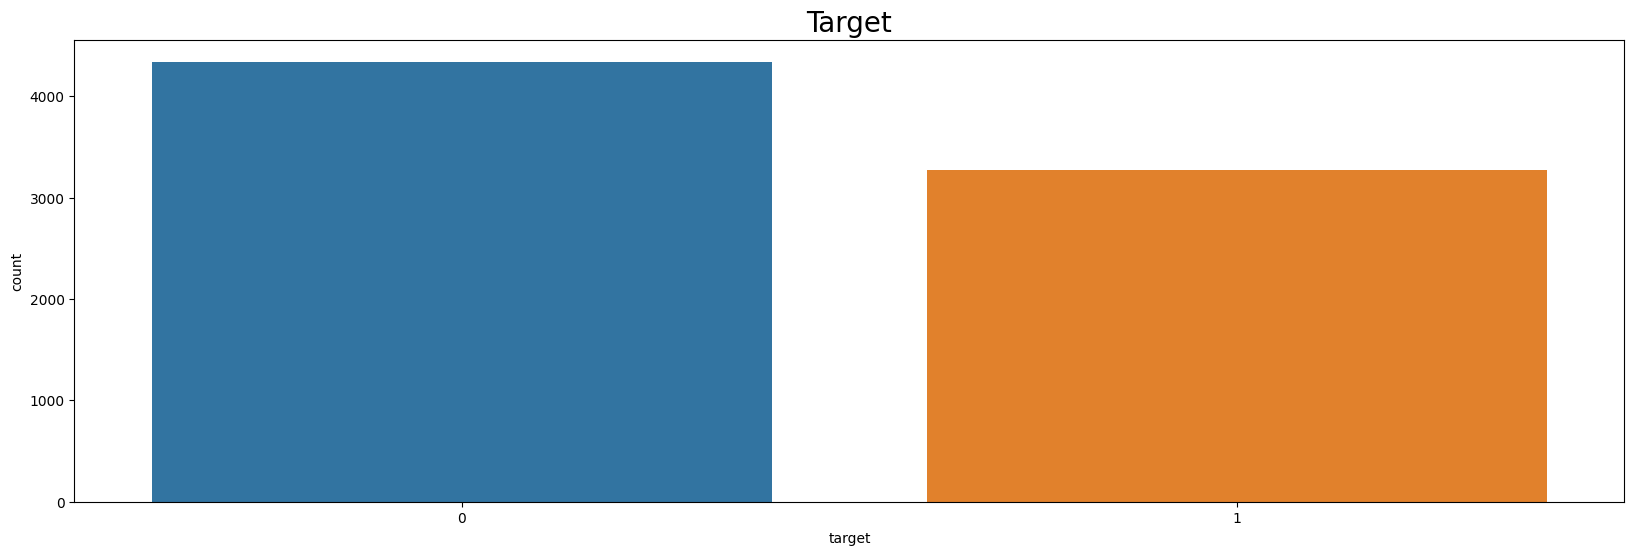

In [19]:
# Check if data is balanced
plt.figure(figsize=(20, 6))
ax = sns.countplot(x=df_train["target"])
ax.set_title("Target", fontsize=20)
plt.show()

In [20]:
# Check different keywords
df_train["keyword"].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [21]:
# Try to find disasters based on some key words
for i in range(len(df_train['text'])):
    if 'earthquake' in df_train['text'][i] or 'hurricane' in df_train['text'][i] or 'flood' in df_train['text'][i] or 'tsunami' in df_train['text'][i] or 'tornado' in df_train['text'][i] or 'wildfire' in df_train['text'][i]:
        print('Disaster found in ' + str(i))

Disaster found in 0
Disaster found in 3
Disaster found in 4
Disaster found in 5
Disaster found in 6
Disaster found in 9
Disaster found in 11
Disaster found in 12
Disaster found in 46
Disaster found in 59
Disaster found in 653
Disaster found in 669
Disaster found in 1128
Disaster found in 1231
Disaster found in 1517
Disaster found in 1710
Disaster found in 2206
Disaster found in 2366
Disaster found in 2369
Disaster found in 2373
Disaster found in 2375
Disaster found in 2376
Disaster found in 2377
Disaster found in 2380
Disaster found in 2382
Disaster found in 2386
Disaster found in 2391
Disaster found in 2392
Disaster found in 2394
Disaster found in 2435
Disaster found in 2827
Disaster found in 2835
Disaster found in 2853
Disaster found in 2854
Disaster found in 2856
Disaster found in 2857
Disaster found in 2860
Disaster found in 2876
Disaster found in 2884
Disaster found in 2915
Disaster found in 3028
Disaster found in 3029
Disaster found in 3030
Disaster found in 3035
Disaster found i

In [86]:
# Try to find disasters based on some hashtags
for i in range(len(df_train['text'])):
    if '#disaster' in df_train['text'][i] or '#nature' in df_train['text'][i] or '#tsunami' in df_train['text'][i] or '#covid' in df_train['text'][i] or '#earthquake' in df_train['text'][i] or '#naturaldisaster' in df_train['text'][i] or '#disasterrelief' in df_train['text'][i] or '#gempabumi' in df_train['text'][i] or '#emergency' in df_train['text'][i] or '#fire' in df_train['text'][i] or '#love' in df_train['text'][i] or '#disastermanagement' in df_train['text'][i] or '#bencanaalarm' in df_train['text'][i]:
        print('Hashtag found in ' + str(i))

Hashtag found in 0
Hashtag found in 6
Hashtag found in 1666
Hashtag found in 1851
Hashtag found in 2179
Hashtag found in 2788
Hashtag found in 3028
Hashtag found in 3038
Hashtag found in 3046
Hashtag found in 3061
Hashtag found in 3150
Hashtag found in 3162
Hashtag found in 3771
Hashtag found in 3793
Hashtag found in 3974
Hashtag found in 3997
Hashtag found in 5018
Hashtag found in 5086
Hashtag found in 5542
Hashtag found in 6024
Hashtag found in 6735
Hashtag found in 6951
Hashtag found in 6956
Hashtag found in 7131
Hashtag found in 7135
Hashtag found in 7298
Hashtag found in 7350
Hashtag found in 7373


In [59]:
hashtags = re.sub(" ",',',"#disaster #nature #tsunami #covid #earthquake #naturaldisaster #disasterrelief #flood #bencana #indonesia #disasterpreparedness #gempabumi #emergency #fire #love #disastermanagement #bencanaalam #hurricane #disasterrecovery #help #earth #gempa #bhfyp #life #disasterresponse #climatechange #disasters #tsunamipalu #viral #world")

In [60]:
print(hashtags.split(',')[0])
    

#disaster


In [61]:
print(hashtags[0])

#


In [62]:
hashtags2 = re.sub(" ",',',"#banjir #photography #chernobyl #storm #water #likuifaksi #floods #india #megatsunami #waterdamage #instagram #tsunamiwarning #gunungmeletus #bmkg #art #longsor #tornado #siagabencana #tsunamiaceh #terremoto #coronavirus #emergencypreparedness #rain #survival #news #safety #bnpb #rescue #history #flooding")

In [63]:
k=0
hashtags_disaster = []
for i in hashtags.split(','):
    for j in df_train['text']:
        if i in j:
            hashtags_disaster.append(k)
        k=k+1
    

In [64]:
disaster = []
for i in range(len(df_train['text'])):
    if df_train['target'][i]==1:
        disaster.append(i)

In [65]:
overlap_disaster = []
for i in disaster:
    if i in hashtags_disaster:
        overlap_disaster.append(i)
        

In [66]:
len(hashtags_disaster)

65

In [67]:
len(overlap_disaster)

6

In [68]:
my_list = [1, 2, 3]
[i for i in my_list if i==2]

[2]

In [69]:
#df_train['text'].values.tolist()
df_train['text'].unique()

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ... http://t.co/nF4IculOje',
       'Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [70]:
df_train.sort_values(by="target", ascending=False, inplace=True)

In [71]:
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
4069,5783,forest%20fires,NaN,When ur friend and u are talking about forest fires in a forest and he tells u to drop ur mix tape out there... #straightfire,1
4067,5780,forest%20fires,"Lansdale,Pennsylvania",U.S. Forest Service says spending more than half of budget on fires: By Ian SimpsonÛ_ http://t.co/UyYYrKd6q3,1
4066,5778,forest%20fires,"Vancouver, BC",Forest fires could delay @AbbyAirshow but officials say it could be a good thing http://t.co/Vxjcx8uKMd,1
4065,5777,forest%20fires,"Portland, Oregon",Inciweb OR Update: Rogue River-Siskiyou National Forest Fires 8/5/15 12:00 PM (Rogue River-Siskiyou NF AreaÛ_ http://t.co/LkwxU8QV7n,1
4064,5776,forest%20fires,Based in CA - Serve Nationwide,Property losses from northern California wildfire nearly double http://t.co/oTfW5SEkD7 via @YahooNews,1
4063,5775,forest%20fires,NaN,U.S. Forest Service says spending more than half of budget on fires http://t.co/1hLVrKwgIP,1
4062,5772,forest%20fires,NaN,CLIMATE CONSEQUENCES: U.S. Forest Service Says Spending More Than Half Of Budget On Fires http://t.co/k0QtL8aODH http://t.co/zQBXe7x9Y7,1
4060,5769,forest%20fires,NaN,#HeartDisease U.S. Forest Service says spending more than half of budget on fires http://t.co/KzfiGkEeva,1
4059,5766,forest%20fires,Duncan,@BlueJays @Braves @Angels Instead of dumping water on yourselves please send it to British Columbia to help with the forest fires,1


In [72]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [73]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [74]:
y=df_train['target'].values
y.shape

(7613,)

In [75]:
x=df_train['text'].values
x.shape

(7613,)

In [76]:
(x_train,x_test,y_train,y_test)=train_test_split(x,y,test_size=0.4)
x_train.shape
y_train.shape
x_test.shape
y_test.shape

NameError: name 'train_test_split' is not defined

In [77]:
df1=pd.DataFrame(x_train)
df1=df1.rename(columns={0:'text'})

NameError: name 'x_train' is not defined

In [78]:
df2=pd.DataFrame(y_train)
df2=df2.rename(columns={0:'target'})
df_df2=pd.concat([df1,df2],axis=1)

NameError: name 'y_train' is not defined

In [79]:
df_df2.head()

NameError: name 'df_df2' is not defined

In [80]:
df3=pd.DataFrame(x_test)
df3=df3.rename(columns={0:'text'})


NameError: name 'x_test' is not defined

In [81]:
df4=pd.DataFrame(y_test)
df4=df2.rename(columns={0:'target'})
df_test=pd.concat([df3,df4],axis=1)

NameError: name 'y_test' is not defined

In [82]:
df_test.head()

NameError: name 'df_test' is not defined

In [83]:
#defining the function to remove punctuation
def remove_punctuation(text):
  if(type(text)==float):
    return text
  ans=""  
  for i in text:     
    if i not in string.punctuation:
      ans+=i    
  return ans

In [84]:
#storing the puntuation free text in a new column called clean_msg
df_df2['text']= df_train['text'].apply(lambda x:remove_punctuation(x))
df_test['text']= df_test['text'].apply(lambda x:remove_punctuation(x))

NameError: name 'string' is not defined

In [18]:
df_df2.head()
#punctuations are removed from news column in train dataset

NameError: name 'df_df2' is not defined